# Sentiment Analysis

This is a basic sentiment analysis model that evaluates the statement between positive and negative statement. These emotions can be further broken down into 'Happy', 'Sad', 'Angry' emotions down the using a similar approach. 

### Importing libraries

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from wordcloud import WordCloud
import re

### Natural language processing

nltk - Natural language processing is a collection of libraries for nlp 


stopwords - a collection of words that dont provide any meaning to a sentence 


WordNetLemmatizer – used to convert different forms of words into a single item but still keeping the context intact.\\

In [43]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rithvik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rithvik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Machine learning

scikit learn -  machine learning library

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

### Evaluation Metrics 

In [45]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix

### Dataset

We will read the dataset (imported from kaggle) and then do some pre-processing

In [10]:
df_train = pd.read_csv("train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("val.txt",delimiter=';',names=['text','label'])

In [11]:
df = pd.concat([df_train,df_val])
df.reset_index(inplace=True,drop=True)

print("Shape of the DataFrame:",df.shape)
print(df.sample(5))

Shape of the DataFrame: (18000, 2)
                                                    text  label
7039   i feel selfish on the days i dont feel well an...  anger
9457   i read premonition i had this rare feeling tha...    joy
14987  im looking forward to feeling hopeful instead ...    joy
13217  i feel the near and lively presence of the wel...    joy
7836   i met a really cute girl who i feel kind of fo...   love


<Axes: xlabel='count', ylabel='label'>

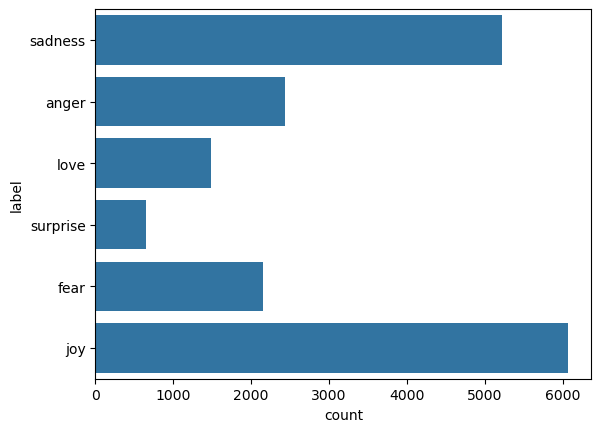

In [12]:
sns.countplot(df.label)

For the sake of simplicity (see multi class sentiment analyser for complex stuff), i will now encode these emotions as positive and negative

In [13]:
def custom_encoder(series):
    return series.replace({
        "surprise": 1,
        "love": 1,
        "joy": 1,
        "fear": 0,
        "anger": 0,
        "sadness": 0
    })

df['label'] = custom_encoder(df['label'])


<Axes: xlabel='label', ylabel='count'>

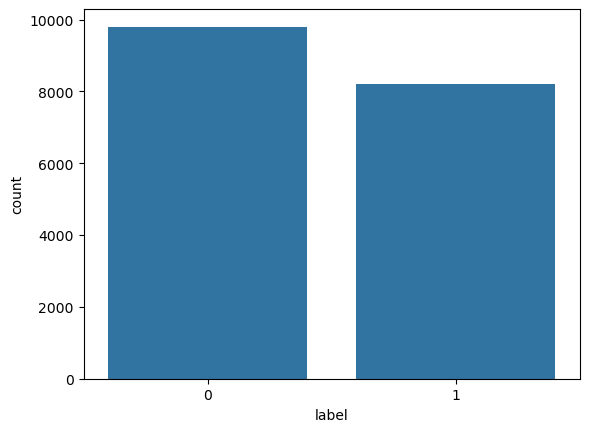

In [14]:
sns.countplot(x=df['label'])

In [15]:
print(df.sample(5))

                                                    text  label
17048  i also feel the circumstances are out of my co...      0
12951  i didn t see anything but as i touched i could...      1
10828                           i feel a bit sentimental      0
10498  i feel so humiliated at failing to achieve wha...      0
17285  i wonder what the other students in my classes...      1


#### Pre processing

For pre-processing:

- First, we will iterate through each record, and using a regular expression, we will get rid of any characters apart from alphabets.
- Then, we will convert the string to lowercase as, the word “Good” is different from the word “good”
- Then we will check for stopwords in the data and get rid of them. Stopwords are commonly used words in a sentence such as “the”, “an”, “to” etc. which do not add much value.
- Then, we will perform lemmatization on each word,i.e. change the different forms of a word into a single item called a lemma.


A lemmatisation transforms a word into its simplest form (lemma) without changing its meaning (context)


For example 'fighting' -> 'fought' -> 'fight'

In [16]:
from nltk.corpus import stopwords
lm = WordNetLemmatizer()

In [17]:
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [18]:
corpus = text_transformation(df['text'])

#### creating a wordCloud

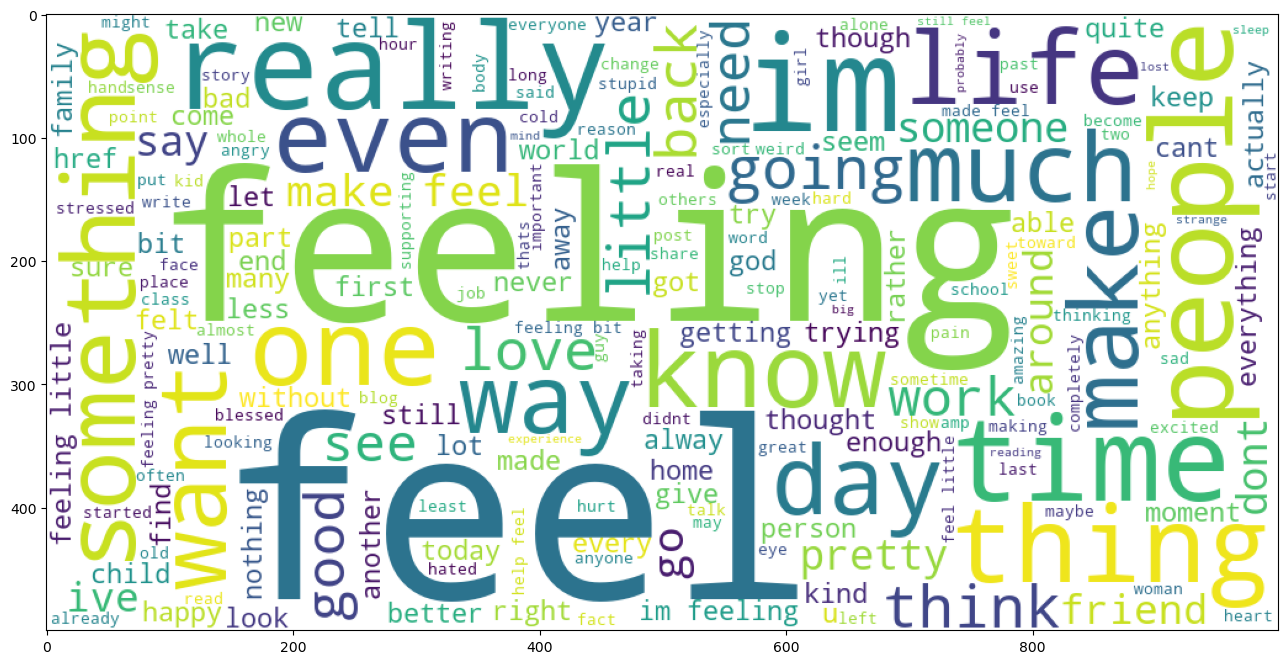

In [19]:
rcParams['figure.figsize'] = 20,8
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

### Bag of Words Model

From above pre-processing we have removed all the semantics in a sentence and reduced it into a 'bag of words' that lends itself meaning.


For example, 'I hate pappaya' -> 'hate' and like so

A key tenant in this model is:


'the grammar and the order of words in a sentence are not given any importance, instead, multiplicity, i.e. (the number of times a word occurs in a document) is the main point of concern.'

Scikit-Learn provides a neat way of performing the bag of words technique using CountVectorizer.

In [25]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(corpus)
X = traindata
y = df.label

print(X.shape)

(18000, 117602)


Ngram is a sequence of ‘n’ of words in a row or sentence. ‘ngram_range’ is a parameter, which we use to give importance to the combination of words, such as, “social media” has a different meaning than “social” and “media” separately.

We can experiment with the value of the ngram_range parameter and select the option which gives better results.

### Machine Learning Model

In [26]:
param_dist = {
    'n_estimators': [500, 1000],
    'max_depth': [5, 10, None],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2', None] 
}


In [27]:
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    random_state=42,
    return_train_score=True,
    error_score='raise'  
)

random_search.fit(X, y)
random_search.best_params_

{'n_estimators': 500,
 'min_samples_split': 15,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [29]:
results_df = pd.DataFrame(random_search.cv_results_)
columns_to_view = [
    'rank_test_score',
    'mean_test_score',
    'std_test_score',
    'params'
]
results_df_sorted = results_df[columns_to_view].sort_values(by='rank_test_score')

print(results_df_sorted.head(10))

    rank_test_score  mean_test_score  std_test_score  \
7                 1         0.956778        0.001021   
10                2         0.956500        0.000720   
9                 3         0.953167        0.000680   
8                 4         0.938722        0.002451   
12                5         0.937222        0.002793   
0                 6         0.931778        0.001220   
15                7         0.928500        0.001361   
6                 8         0.927667        0.002190   
16                9         0.914556        0.002518   
11               10         0.590722        0.003163   

                                               params  
7   {'n_estimators': 500, 'min_samples_split': 15,...  
10  {'n_estimators': 1000, 'min_samples_split': 10...  
9   {'n_estimators': 500, 'min_samples_split': 15,...  
8   {'n_estimators': 1000, 'min_samples_split': 10...  
12  {'n_estimators': 1000, 'min_samples_split': 5,...  
0   {'n_estimators': 500, 'min_samples_split': 

In [31]:
rfc = RandomForestClassifier(
    max_features=random_search.best_params_['max_features'],
    max_depth=random_search.best_params_['max_depth'],
    n_estimators=random_search.best_params_['n_estimators'],
    min_samples_split=random_search.best_params_['min_samples_split'],
    min_samples_leaf=random_search.best_params_['min_samples_leaf'],
    bootstrap=random_search.best_params_['bootstrap']
)

rfc.fit(X, y)


RandomForestClassifier(min_samples_leaf=2, min_samples_split=15,
                       n_estimators=500)

### Test data

In [39]:
test_df = pd.read_csv('test.txt',delimiter=';',names=['text','label'])

In [40]:
# Preprocessing
X_test = test_df.text

# Encode string labels to numbers (and update y_test!)
test_df['label'] = custom_encoder(test_df['label'])
y_test = test_df['label']

# Transform the text
test_corpus = text_transformation(X_test)

# Vectorize
testdata = cv.transform(test_corpus)

# Predict
predictions = rfc.predict(testdata)

### Model evaluation

In [48]:
rcParams['figure.figsize'] = 10, 5

acc_score = accuracy_score(y_test, predictions)
pre_score = precision_score(y_test, predictions)
rec_score = recall_score(y_test, predictions)

print('Accuracy_score: ', acc_score)
print('Precision_score:', pre_score)
print('Recall_score:   ', rec_score)
print("-" * 50)
print(classification_report(y_test, predictions))

Accuracy_score:  0.9655
Precision_score: 0.9743589743589743
Recall_score:    0.95
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1080
           1       0.97      0.95      0.96       920

    accuracy                           0.97      2000
   macro avg       0.97      0.96      0.97      2000
weighted avg       0.97      0.97      0.97      2000



### Custom Input 

In [49]:
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Positive Sentiment.")
    else:
        print("Invalid Statement.")

In [50]:
def sentiment_predictor(input):
    input = text_transformation(input)
    transformed_input = cv.transform(input)
    prediction = rfc.predict(transformed_input)
    expression_check(prediction)

In [51]:
input = ["I am supper tired"]

In [52]:
sentiment_predictor(input);

Input statement has Negative Sentiment.
